<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Mount Google Drive

drive.mount('/content/drive')

# Step 2: Clone the GitHub Repository
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git

# Step 3: Collect Paths and Labels

paths = []
labels = []

# Define the path to the dataset
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'

# Walk through the directory and collect file paths and labels
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        # Extract label from the filename
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

    # Break if we've collected a specified number of files, if needed
    if len(paths) == 2800:  # Adjust this number as necessary
        break

print('Dataset is Loaded')


Mounted at /content/drive
Cloning into 'SoundSense-Sentiment-Analysis'...
remote: Enumerating objects: 2830, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 2830 (delta 1), reused 6 (delta 0), pack-reused 2818
Receiving objects: 100% (2830/2830), 214.53 MiB | 20.95 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (5602/5602), done.
Dataset is Loaded


In [3]:
len(paths)

2800

In [4]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_wag_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_came_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_hit_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_take_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_thin_disgust.wav']

In [5]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
1,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
2,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
3,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
4,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust


In [7]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [8]:
df['label'].value_counts()

label
ps         800
angry      600
disgust    400
fear       400
neutral    400
sad        200
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

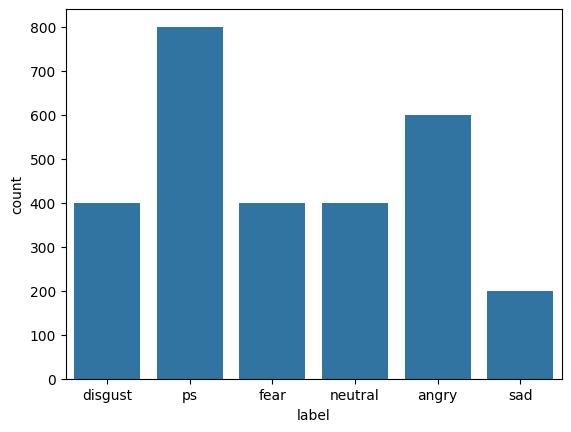

In [9]:
sns.countplot(data=df, x='label')

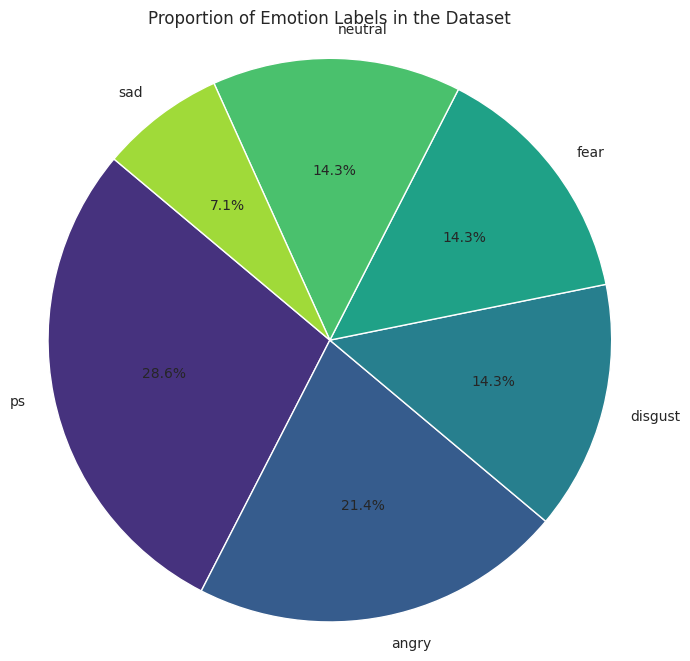

In [10]:
# Get label counts
label_counts = df['label'].value_counts()
# Data for the pie chart
labels = label_counts.index
counts = label_counts.values
colors = sns.color_palette('viridis', len(labels))
# Set Seaborn style
sns.set_style("whitegrid")
# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Emotion Labels in the Dataset')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [11]:
def plot_with_title(emotion, title, figsize=(10, 4), size=20):
    plt.figure(figsize=figsize)
    plt.title(f"{emotion}: {title}", fontsize=size, fontweight='bold', color='navy')

def waveplot(data, sr, emotion):
    plot_with_title(emotion, "Waveform")
    librosa.display.waveshow(data, sr=sr, color='dodgerblue', alpha=0.8, linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('Amplitude', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()

def mfcc(data, sr, emotion):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plot_with_title(emotion, "MFCCs", figsize=(10, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('MFCC Coefficients', fontsize=15, fontweight='bold', color='darkslategray')
    plt.tight_layout()
    plt.show()

def zero_crossing_rate(data, sr, emotion):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    plot_with_title(emotion, "Zero Crossing Rate", figsize=(10, 4))
    plt.plot(zcr[0], color='crimson')
    plt.xlabel('Frame', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('ZCR', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


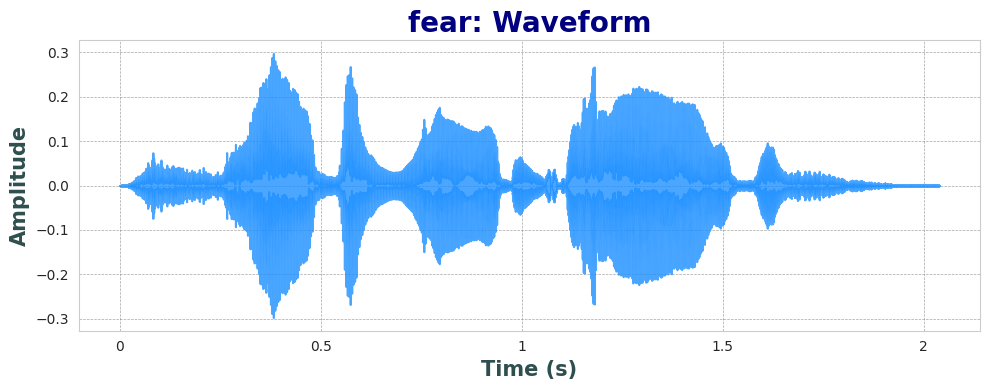

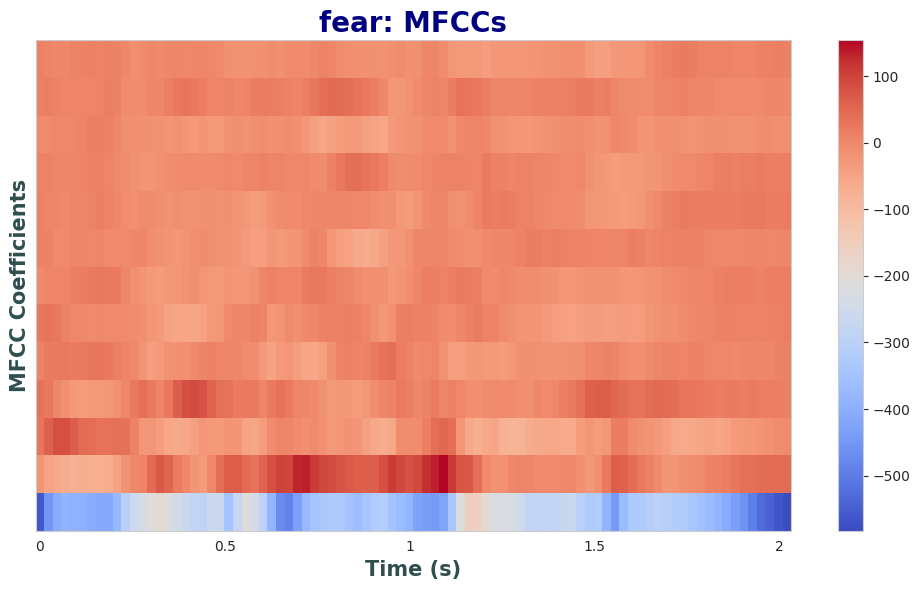

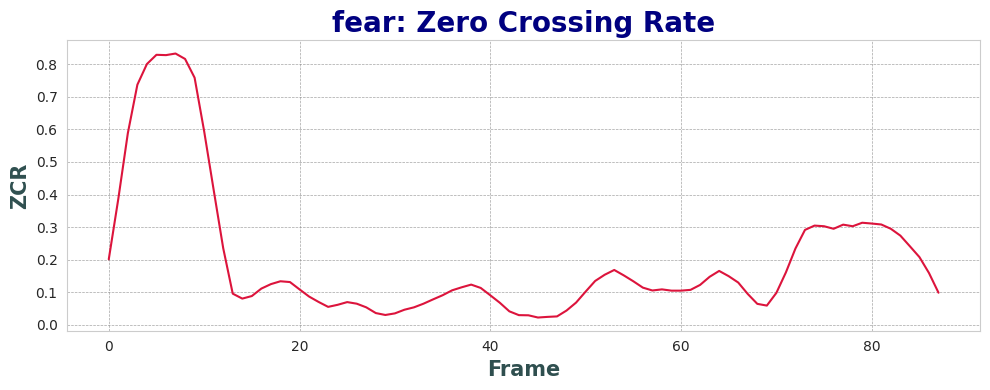

In [12]:
emotion = 'fear'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

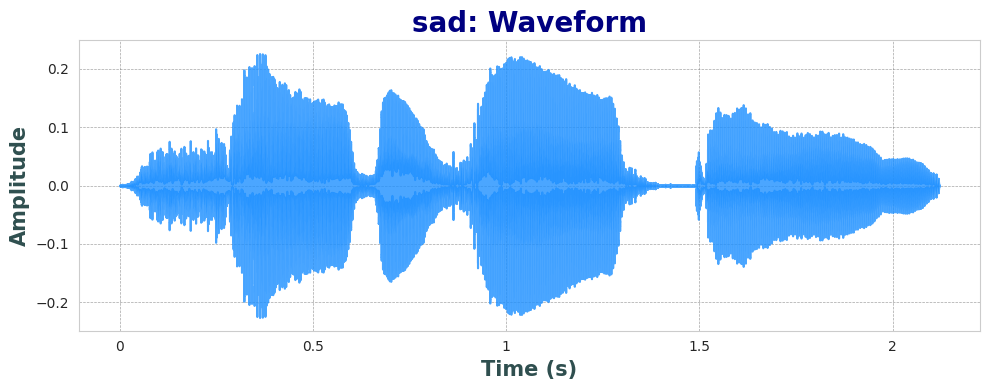

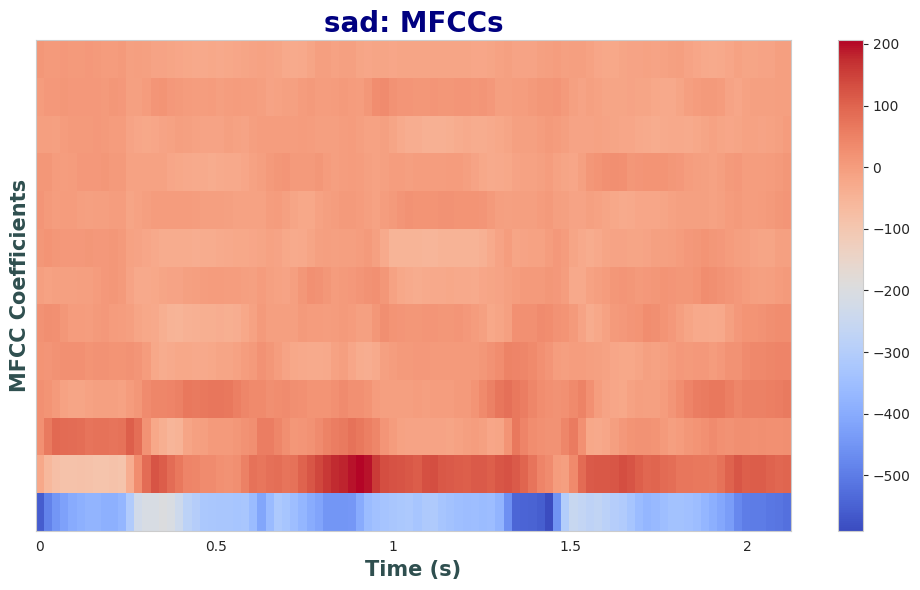

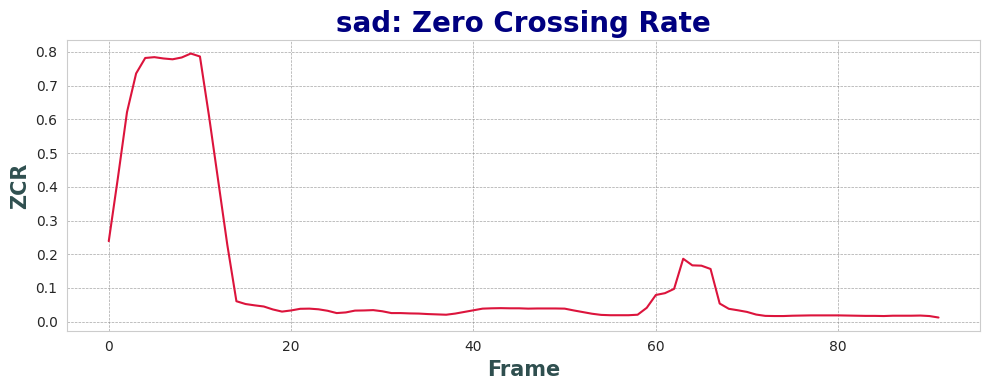

In [13]:
emotion = 'sad'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

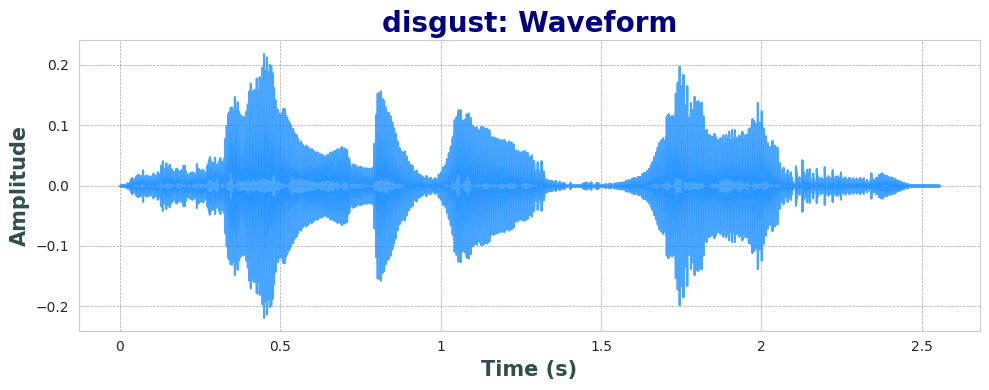

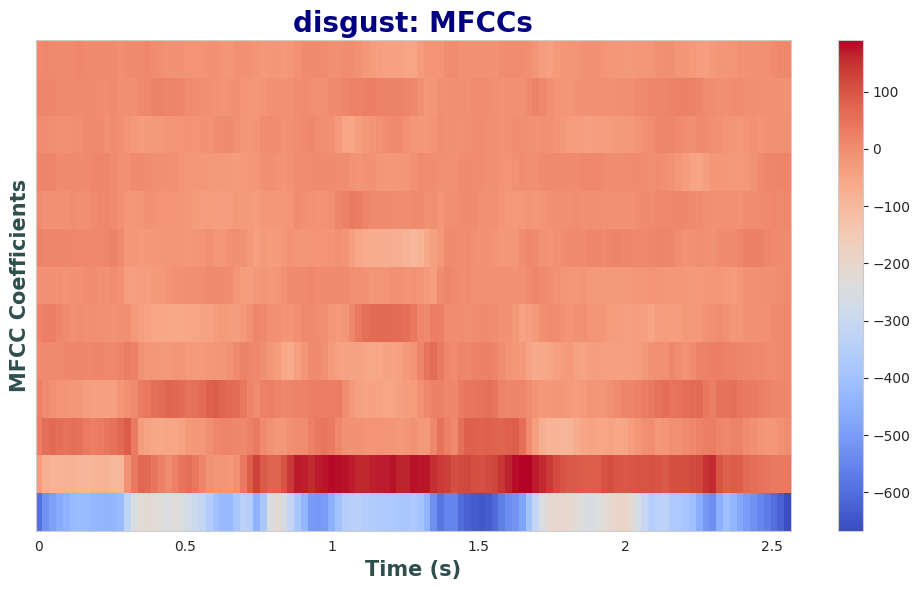

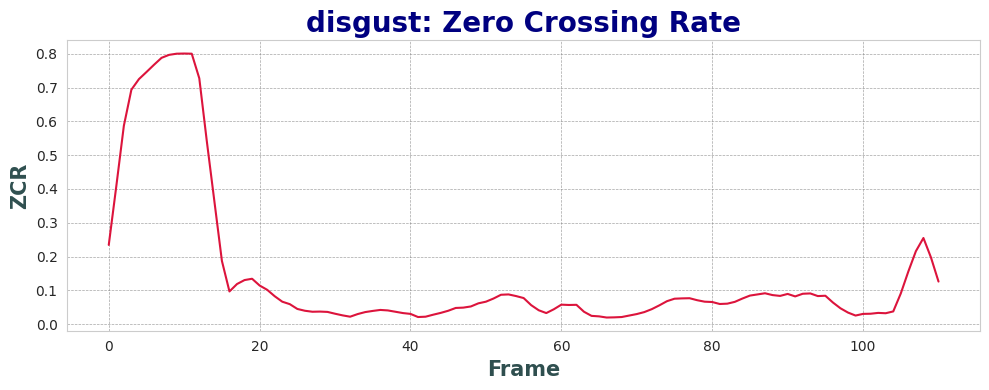

In [14]:
emotion = 'disgust'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

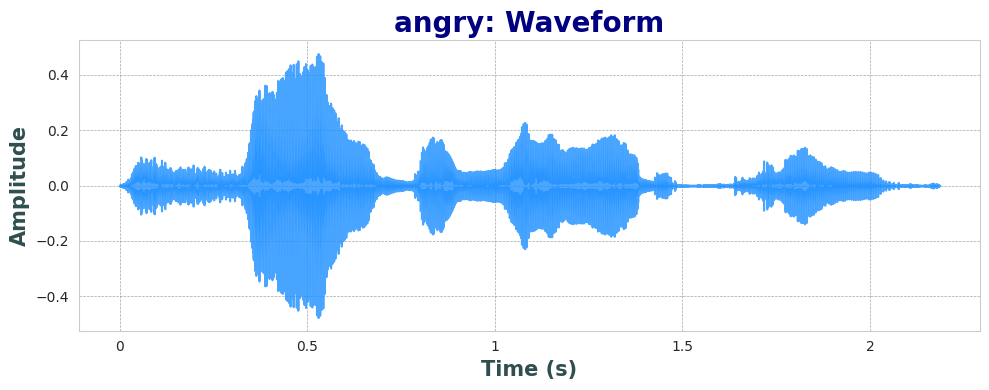

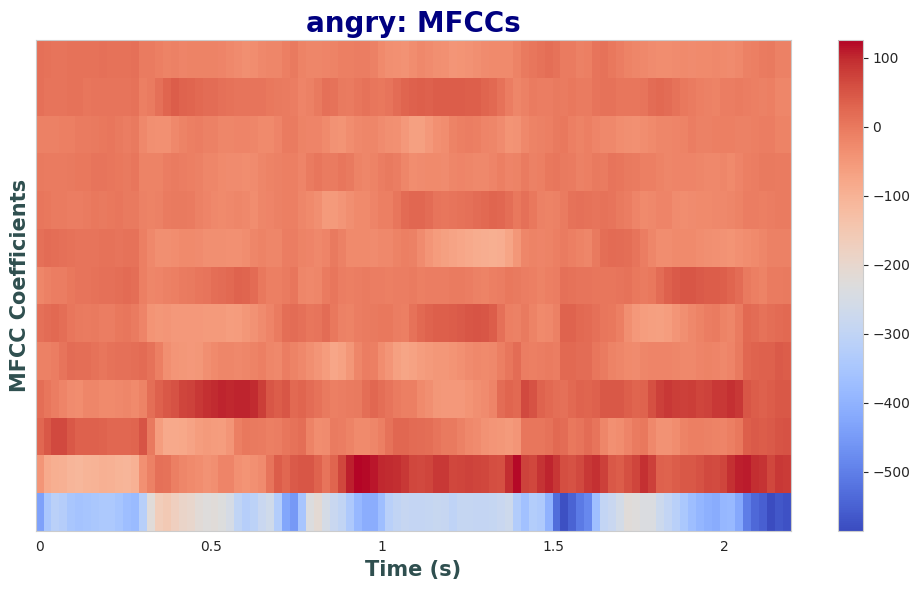

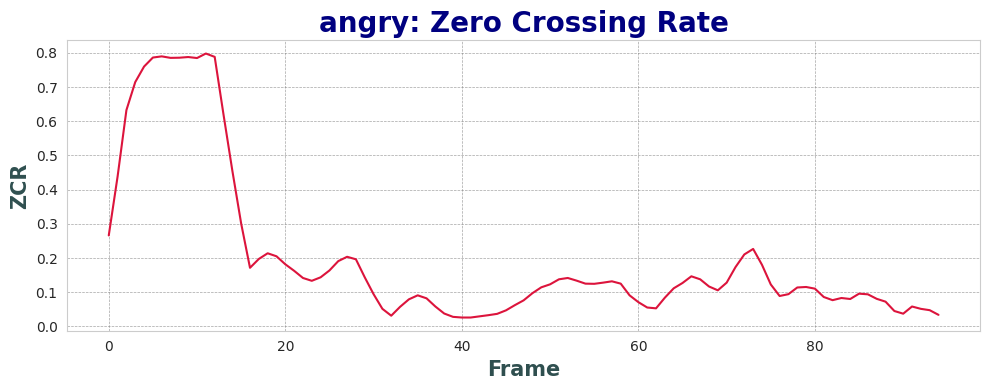

In [15]:
emotion = 'angry'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

In [16]:
def extract_mfcc(filename, duration=3, offset=0.5, n_mfcc=40):
    """
    Extracts the mean Mel Frequency Cepstral Coefficients (MFCC) from an audio file.

    Parameters:
        filename (str): Path to the audio file.
        duration (float): Duration of the audio to be loaded (in seconds). Default is 3 seconds.
        offset (float): Start reading after this time (in seconds). Default is 0.5 seconds.
        n_mfcc (int): Number of MFCCs to extract. Default is 40.

    Returns:
        np.ndarray: Array containing the mean MFCC values.
    """
    try:
        # Load the audio file
        audio_data, sample_rate = librosa.load(filename, duration=duration, offset=offset)

        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

        # Calculate the mean MFCC across time
        mean_mfcc = np.mean(mfcc_features.T, axis=0)

        return mean_mfcc

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

In [17]:
def get_mfcc_features(speech):
    return extract_mfcc(speech)

In [43]:
# Extract MFCC features for all speech samples in the dataframe
X_mfcc = df['speech'].apply(get_mfcc_features)

In [19]:
# Convert the list of MFCC feature arrays into a numpy array
X = np.array([x for x in X_mfcc])

# Check the shape of the resulting feature array
print(X.shape)

(2800, 40)


In [20]:
# Expand dimensions to match the expected input shape for neural networks
X = np.expand_dims(X, -1)

# Check the shape after expanding dimensions
print(X.shape)

(2800, 40, 1)


In [21]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

# Check the shape of the encoded labels
print(y.shape)

(2800, 6)


In [22]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting training and validation sets
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2240, 40, 1) (560, 40, 1) (2240, 6) (560, 6)


In [47]:
from keras import layers
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 40, 256)           1536      
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 20, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 20, 256)           327936    
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 10, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 10, 128)           163968    
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 5, 128)          

In [48]:
import tensorflow as tf
early_stop = EarlyStopping(monitor='val_loss', patience=3)


In [50]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
35/35 [==============================] - 6s 129ms/step - loss: 2.2577 - accuracy: 0.2330 - val_loss: 1.4437 - val_accuracy: 0.5125
Epoch 2/50
35/35 [==============================] - 6s 182ms/step - loss: 1.2243 - accuracy: 0.5094 - val_loss: 0.5406 - val_accuracy: 0.7946
Epoch 3/50
35/35 [==============================] - 4s 122ms/step - loss: 0.6255 - accuracy: 0.7509 - val_loss: 0.1485 - val_accuracy: 0.9821
Epoch 4/50
35/35 [==============================] - 4s 123ms/step - loss: 0.3806 - accuracy: 0.8531 - val_loss: 0.0535 - val_accuracy: 0.9929
Epoch 5/50
35/35 [==============================] - 6s 181ms/step - loss: 0.2577 - accuracy: 0.9143 - val_loss: 0.0336 - val_accuracy: 0.9946
Epoch 6/50
35/35 [==============================] - 4s 122ms/step - loss: 0.1880 - accuracy: 0.9429 - val_loss: 0.0542 - val_accuracy: 0.9875
Epoch 7/50
35/35 [==============================] - 4s 120ms/step - loss: 0.1373 - accuracy: 0.9576 - val_loss: 0.0201 - val_accuracy: 0.9911
Epoch 

In [56]:
model1 = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 6)               

In [57]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
35/35 [==============================] - 10s 201ms/step - loss: 0.8786 - accuracy: 0.6513 - val_loss: 0.1970 - val_accuracy: 0.9196
Epoch 2/50
35/35 [==============================] - 5s 151ms/step - loss: 0.1520 - accuracy: 0.9554 - val_loss: 0.0666 - val_accuracy: 0.9804
Epoch 3/50
35/35 [==============================] - 7s 210ms/step - loss: 0.1314 - accuracy: 0.9571 - val_loss: 0.0535 - val_accuracy: 0.9786
Epoch 4/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0544 - accuracy: 0.9844 - val_loss: 0.0434 - val_accuracy: 0.9893
Epoch 5/50
35/35 [==============================] - 7s 193ms/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.0394 - val_accuracy: 0.9893
Epoch 6/50
35/35 [==============================] - 6s 159ms/step - loss: 0.0378 - accuracy: 0.9884 - val_loss: 0.0177 - val_accuracy: 0.9929
Epoch 7/50
35/35 [==============================] - 5s 153ms/step - loss: 0.0291 - accuracy: 0.9920 - val_loss: 0.0161 - val_accuracy: 0.9911
Epoch